# Проект для "Викишоп" с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других.
_____
<b>Цель проекта:</b>

Создать инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Обучить модель классифицировать комментарии на позитивные и негативные.

_____

<b>Задачи проекта</b>

- Загрузить и подготовьть данные
- Обучить модель классифицировать комментарии на позитивные и негативные
- Построить модель со значением метрики качества F1 не меньше 0.75. 
_____

<b>Описание данных</b>

Набор данных с разметкой о токсичности правок. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

Данное исследование разделим на несколько частей.

[***ШАГ 1. Подготовка данных***](#1) 

[***ШАГ 2. Исследовательский анализ***](#2) 

[***ШАГ 3. Модель без BERT***](#3)  

[***ШАГ 4. Модель с BERT***](#4)  

[***ШАГ 5. Выводы***](#5)
_________________

<a id='1'></a>
## Подготовка данных

In [ ]:
pip install scikit-learn==1.3.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 67.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 69.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
imbalanced-learn 0.14.1 requires scikit-learn<2,>=1.4.2, but you have scikit-learn 1.3.2 which is incompatible.
umap-learn 0.5.11 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [ ]:
import torch
print("TORCH OK")

TORCH OK


In [ ]:
!pip install spacy -q

In [ ]:
pip install wordcloud -q

In [ ]:
!pip -q install --upgrade --force-reinstall "numpy==1.26.4" "pandas==2.2.2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 100.2 MB/s eta 0:00:0000:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 kB 24.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
imbalanced-learn 0.14.1 requires scikit-learn<2,>=1.4.2, but you have scikit-learn 1.3.2 which is incompatible.
umap

In [1]:
import re
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import torch
from torch import nn
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # ускоряем

In [3]:
from google.colab import drive
drive.mount("/content/drive")

KeyboardInterrupt: 

In [ ]:
pd.set_option('display.max_colwidth', None)   

In [2]:
import os
os.listdir('/content')

['.config', 'sample_data']

In [3]:
data = pd.read_csv('/content/toxic_comments.csv')
def show_df_info(df, name='DataFrame'):
    """
    Отображает основные сведения о датасете:
    - первые строки
    - информацию о типах данных и пропусках
    - описательную статистику
    """
    buffer = StringIO()
    
    buffer.write(f'\n=== {name} ===\n')

    buffer.write('\nПервые строки:\n')
    buffer.write(df.head().to_string())
    buffer.write('\n')

    buffer.write('\nИнформация о данных:\n')
    df.info(buf=buffer)        
    buffer.write('\n')

    buffer.write('\nОписательная статистика:\n')
    buffer.write(df.describe(include="all").to_string())
    buffer.write('\n')

    print(buffer.getvalue())

show_df_info(data, 'toxic comments')

FileNotFoundError: [Errno 2] No such file or directory: '/content/toxic_comments.csv'

Данные содержат 159 292 комментария и три стобца. Нам необходимы только два - text и toxic

In [ ]:
data = data.dropna(subset=['text', 'toxic'])

<a id='2'></a>
## Исследовательский анализ

Для начала я хочу посмотреть баланс классов - сколько токсичных комментариев против не токсичных.

,count,share
toxic,,
0,143106,0.898388
1,16186,0.101612


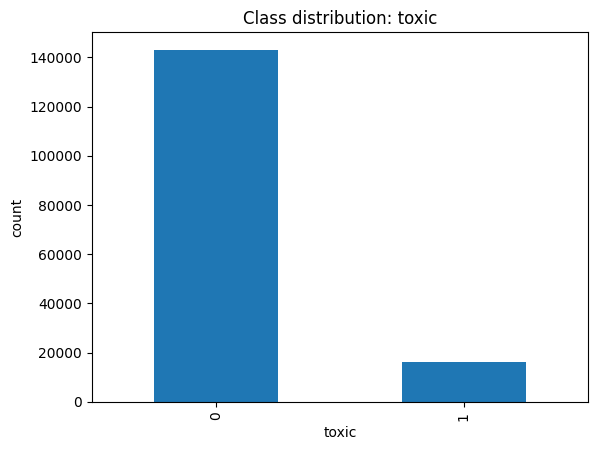

In [ ]:
class_counts = data['toxic'].value_counts()
class_share = data['toxic'].value_counts(normalize=True)

display(pd.DataFrame({'count': class_counts, 'share': class_share}))

class_counts.plot(kind='bar')
plt.title('Class distribution: toxic')
plt.xlabel('toxic')
plt.ylabel('count')
plt.show()

Явный дисбаланс классов - не токсичных комментариев в 8 раз больше. Это необходимо будет учитыать при обучении.

In [ ]:
data['len_chars'] = data['text'].str.len()

# грубо по словам (быстро и достаточно для EDA)
data['len_words'] = data['text'].str.findall(r"\b\w+\b").str.len()

data[['len_chars','len_words']].describe(percentiles=[.5,.75,.9,.95,.99])

,len_chars,len_words
count,159292.000000,159292.000000
mean,393.691303,69.109083
std,590.111825,102.090738
min,5.000000,0.000000
50%,205.000000,37.000000
75%,435.000000,77.000000
90%,889.000000,156.000000
95%,1354.000000,235.000000
99%,3441.090000,587.000000
max,5000.000000,1403.000000


Большинство комментариев относительно короткие, но в данных присутствует длинный хвост из очень больших текстов. 

Сделаем сравнение токсик vs нетоксик:

,mean,50%,75%,90%,95%,99%
toxic,,,,,,
0,403.956585,216.0,452.00,915.0,1385.00,3366.0
1,302.932411,128.0,282.75,605.0,1021.75,4370.9


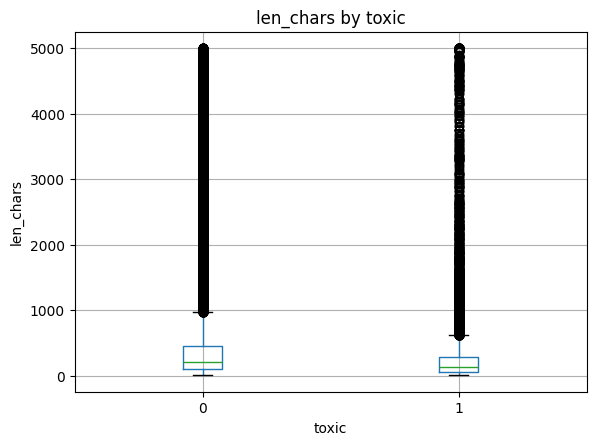

,mean,50%,75%,90%,95%,99%
toxic,,,,,,
0,70.734763,39.0,80.0,160.0,240.0,580.00
1,54.735883,24.0,52.0,109.0,183.0,681.45


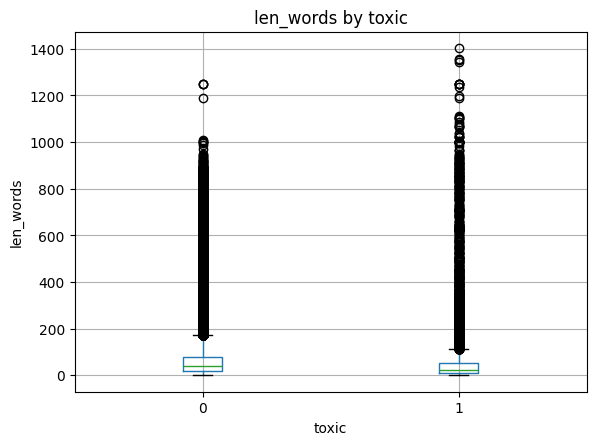

In [ ]:
for col in ['len_chars', 'len_words']:
    grp = (
        data
        .groupby('toxic')[col]
        .describe(percentiles=[.5, .75, .9, .95, .99])
        [['mean', '50%', '75%', '90%', '95%', '99%']]
    )
    display(grp)

    data.boxplot(column=col, by='toxic')
    plt.title(f'{col} by toxic')
    plt.suptitle('')
    plt.xlabel('toxic')
    plt.ylabel(col)
    plt.show()

Токсичные комментарии в среднем короче, чем нетоксичные:
- медиана — 128 символов и 24 слова против 216 символов и 39 слов у нетоксичных.
- на всех перцентилях до 95% токсичные тексты остаются короче, что указывает на более краткую и резкую форму высказываний.
- хвост распределения у токсичных длиннее на 99% (особенно по символам), то есть встречаются редкие, но очень длинные токсичные сообщения.

Еще можно посмотреть эмоциональную окраску комментариев, через символы - капс, восклицания, знаки.

In [ ]:
data['share_upper'] = data['text'].apply(lambda s: sum(c.isupper() for c in s) / max(1, len(s)))
data['exclam_cnt'] = data['text'].str.count('!')
data['quest_cnt']  = data['text'].str.count(r'\?')
data['bad_symbols'] = data['text'].str.count(r'[#@$%^&*]')

features = ['share_upper','exclam_cnt','quest_cnt','bad_symbols']

data.groupby('toxic')[features].mean()

,share_upper,exclam_cnt,quest_cnt,bad_symbols
toxic,,,,
0,0.044905,0.343487,0.433329,0.169238
1,0.110978,3.474669,0.587977,0.186396


Большие буквы и восклицательные знаки — как сигналы токсичности).

Посмотрим слова, которые наиболее характерны для токсика через log-odds. Анализ log-odds позволяет выявить слова, которые наиболее характерны именно для токсичных и нетоксичных комментариев, а не просто часто встречаются в тексте.

In [ ]:
alpha = 1.0  # сглаживание
toxic_prob = (toxic_counts + alpha) / (toxic_counts.sum() + alpha * len(vocab))
nontoxic_prob = (nontoxic_counts + alpha) / (nontoxic_counts.sum() + alpha * len(vocab))

log_odds = np.log(toxic_prob / nontoxic_prob)

top_pos = log_odds.argsort()[-30:][::-1]   # характерно для токсика
top_neg = log_odds.argsort()[:30]          # характерно для нетоксика

display(pd.DataFrame({'word': vocab[top_pos], 'log_odds': log_odds[top_pos]}))
display(pd.DataFrame({'word': vocab[top_neg], 'log_odds': log_odds[top_neg]}))

,word,log_odds
0,cocksucker,8.735019
1,mothjer,8.617689
2,fggt,8.592894
3,hanibal911you,8.328646
4,niggas,8.269723
5,cocksucking,8.096607
6,nhrhs2010,7.701398
7,dickhead,7.682080
8,licker,7.680779
9,fucker,7.655728


,word,log_odds
0,f5fffa,-4.147599
1,specified,-3.824759
2,coupled,-3.602582
3,newsletter,-3.595309
4,tutorial,-3.530825
5,align,-3.502753
6,cellpadding,-3.500972
7,specifies,-3.393827
8,wizard,-3.387857
9,vertical,-3.384859


Для токсичных комментариев характерны выраженно оскорбительные, агрессивные слова, имеющие высокий положительный log-odds, что указывает на их сильную связь с токсичностью. В нетоксичных комментариях, напротив, выделяются нейтральные технические и информационные термины, связанные с оформлением, документацией и обсуждением контента.

### Лемматизация и облако слов

Перед обучением обычными моделями применим лемматизацию текста с использованием spaCy.
Это позволит привести слова к нормальной форме и наглядно выявить характерные лексические различия между токсичными и нетоксичными комментариями.

In [ ]:
def lemmatize_text(text):
    doc = nlp(text.lower())
    lemmas = [
        token.lemma_
        for token in doc
        if not token.is_punct
        and not token.like_num
        and len(token.lemma_) > 2
    ]
    return " ".join(lemmas)

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
texts = data["text"].astype(str).tolist()

def lemmatize_docs(docs):
    out = []
    for doc in docs:
        lemmas = [
            t.lemma_.lower()
            for t in doc
            if not t.is_punct
            and not t.like_num
            and not t.is_space
            and len(t.lemma_) > 1
        ]
        out.append(" ".join(lemmas))
    return out

# batch + многопроцессность (Windows: лучше поставить n_process=1..2)
docs = nlp.pipe(texts, batch_size=256, n_process=1)  # попробуй 1, потом 2
data["lemma_text"] = lemmatize_docs(docs)

data[["text", "lemma_text"]].sample(5)

,text,lemma_text
102634,"It IS true, so shut up and watch the show, why...",it be true so shut up and watch the show why d...
103128,"Welcome!\n\nHello, , and welcome to Wikipedia!...",welcome hello and welcome to wikipedia thank y...
43486,"Well if there are three-to-five of them, clear...",well if there be to of they clearly they be no...
128305,I contacted both CounterPunch and Werther to a...,contact both counterpunch and werther to appra...
93258,"""Hi... I just want to say that the picture of ...",hi just want to say that the picture of mana b...


In [ ]:
text_non_toxic = " ".join(data[data['toxic'] == 0]['lemma_text'])
text_toxic = " ".join(data[data['toxic'] == 1]['lemma_text'])

Для визуального анализа текста построим облака слов отдельно для токсичных и нетоксичных комментариев.

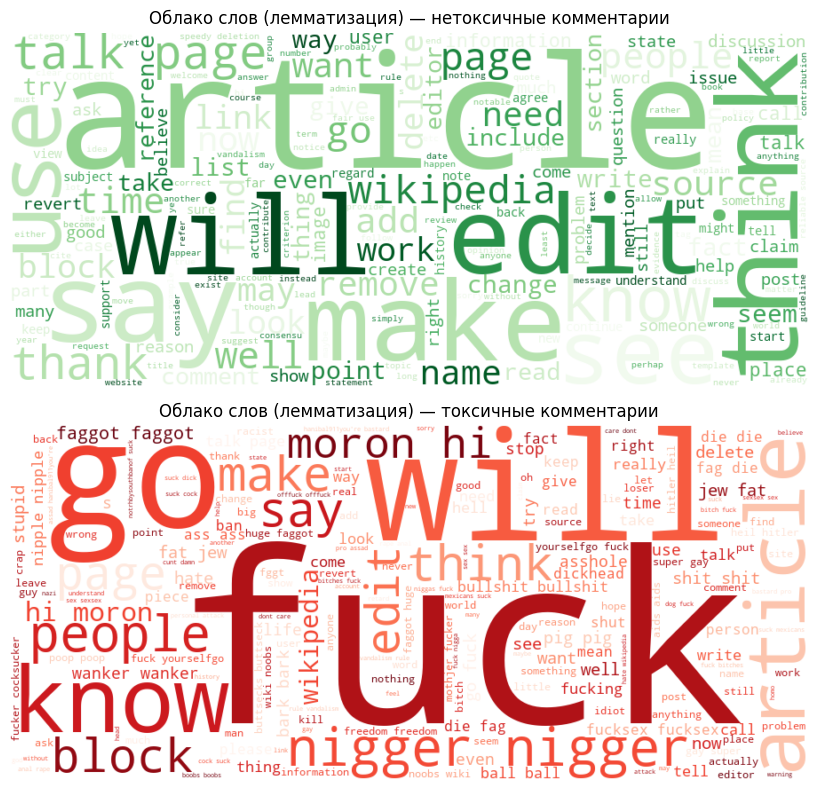

In [ ]:
wc_non_toxic = WordCloud(
    width=900,
    height=400,
    background_color='white',
    max_words=200,
    colormap='Greens'
).generate(text_non_toxic)

wc_toxic = WordCloud(
    width=900,
    height=400,
    background_color='white',
    max_words=200,
    colormap='Reds'
).generate(text_toxic)

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.imshow(np.array(wc_non_toxic.to_image()), interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов (лемматизация) — нетоксичные комментарии')

plt.subplot(2, 1, 2)
plt.imshow(np.array(wc_toxic.to_image()), interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов (лемматизация) — токсичные комментарии')

plt.tight_layout()
plt.show()

После нормализации словоформ различия в словарях стали более выраженными:
- нетоксичные комментарии содержат нейтральную лексику, связанную с обсуждением правок и источников,
- токсичные характеризуются преобладанием оскорбительной и эмоционально окрашенной лексики.

Полученные наблюдения подтверждают наличие сильного лексического сигнала токсичности.

### Выводы исследовательского анализа

В ходе исследовательского анализа было выявлено, что датасет содержит комментарии с существенным разбросом по длине: большинство текстов относительно короткие, однако присутствует длинный хвост из очень объёмных сообщений. 

Токсичные комментарии в среднем короче нетоксичных и чаще имеют прямую, эмоционально окрашенную форму, что подтверждается анализом длины текстов и частотного словаря. 

Частотный анализ и log-odds показали, что токсичность тесно связана с агрессивной и оскорбительной лексикой, тогда как нетоксичные комментарии характеризуются нейтральным и информационным стилем. 

Кроме того, в данных наблюдается выраженный дисбаланс классов: около 90% комментариев являются нетоксичными и лишь ~10% — токсичными, что обосновывает выбор метрики F1 и использование методов, устойчивых к несбалансированным данным.

<a id='3'></a>
## Моделирование без BERT

Для моделирования я хочу посмотреть какой результат будет лучше с леммами или без, поэтому для чистоты эксперимента выделю через сплит сырые данные (raw), а данные с леммами возьму теже строки по индексам.

Для решения задачия выбрала линейные модели Logistic Regression и LinearSVC, эффективно работающие с TF-IDF представлением текста.

In [ ]:
X = data[['text', 'lemma_text']].copy()
y = data['toxic'].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Для эксперимента я сделаю трансформер выбора колонки (сырой текст или лемматизированный), для встройки в пайплайн.

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col='text'):
        self.col = col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.col].astype(str).values

In [ ]:
pipe = Pipeline([
    ('selector', ColumnSelector(col='text')),
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression()) 
])

In [ ]:
param_grid = [
    # LogisticRegression
    {
        'selector__col': ['text', 'lemma_text'],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'tfidf__min_df': [1, 2, 5],
        'tfidf__max_df': [0.9, 0.95, 1.0],
        'clf': [LogisticRegression(max_iter=2000, n_jobs=-1)],
        'clf__C': [0.5, 1, 2, 4],
        'clf__class_weight': [None, 'balanced']
    },

    # LinearSVC
    {
        'selector__col': ['text', 'lemma_text'],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'tfidf__min_df': [1, 2, 5],
        'tfidf__max_df': [0.9, 0.95, 1.0],
        'clf': [LinearSVC()],
        'clf__C': [0.5, 1, 2, 4]
    }
]

In [ ]:
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Лучшие параметры:")
print(grid.best_params_)
print("CV F1:", grid.best_score_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


c:\Users\malen\OneDrive\Desktop\data_since\мастерская 1\.venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Лучшие параметры:
{'clf': LinearSVC(), 'clf__C': 1, 'selector__col': 'lemma_text', 'tfidf__max_df': 0.9, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
CV F1: 0.7877069447792072


В результате подбора гиперпараметров лучшая модель была получена для TF-IDF + LinearSVC.

В данной конфигурации победили только униграммы и повышенное значение min_df, что снижает влияние редких словоформ.
В этих условиях модель на лемматизированных текстах показала более стабильное качество на кросс-валидации.

In [ ]:
best_model = grid.best_estimator_
pred = best_model.predict(X_test)

print("TEST F1:", f1_score(y_test, pred))
print(classification_report(y_test, pred))

TEST F1: 0.7996569468267583
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28622
           1       0.90      0.72      0.80      3237

    accuracy                           0.96     31859
   macro avg       0.93      0.86      0.89     31859
weighted avg       0.96      0.96      0.96     31859



Лучшая модель: TF-IDF + LinearSVC          
Представление текста: лемматизированный (lemma_text)           
TF-IDF параметры:
- ngram_range = (1, 1)
- min_df = 5
- max_df = 0.9

Качество:
- CV F1: 0.7877
- TEST F1: 0.7997

Требование задачи (F1 ≥ 0.75) выполнено с запасом.

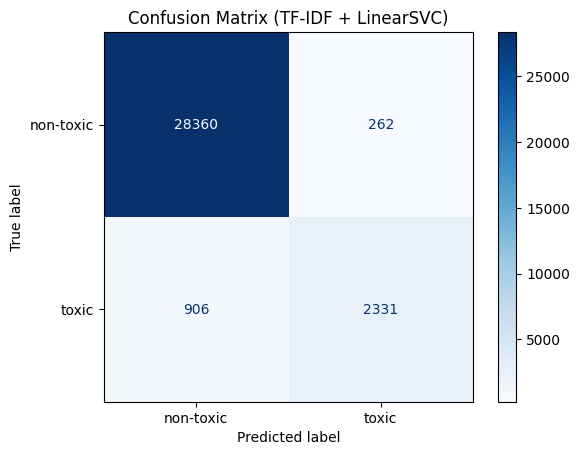

In [ ]:
cm = confusion_matrix(y_test, pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['non-toxic', 'toxic']
)

disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (TF-IDF + LinearSVC)')
plt.show()

В целом модель не плохо предсказывает не токсичные комментарии, ошибка по токсичном выше. Скорее всего это обусловлено дисбалансом классов.     
Теперь посмотрим какие слова оказались в топе (toxic / non-toxic)

In [ ]:
# лучший классификатор
svc = best_model.named_steps['clf']
tfidf = best_model.named_steps['tfidf']

feature_names = np.array(tfidf.get_feature_names_out())
coef = svc.coef_.ravel()  # веса признаков

In [ ]:
top_pos_idx = np.argsort(coef)[-20:][::-1]

top_toxic_words = pd.DataFrame({
    'word': feature_names[top_pos_idx],
    'weight': coef[top_pos_idx]
})

top_toxic_words

,word,weight
0,fuck,10.698449
1,fucking,7.687493
2,shit,6.467391
3,idiot,6.080680
4,bitch,5.990656
5,asshole,5.640207
6,bullshit,5.596505
7,suck,5.446728
8,ass,5.280055
9,stupid,5.200653


In [ ]:
top_neg_idx = np.argsort(coef)[:20]

top_nontoxic_words = pd.DataFrame({
    'word': feature_names[top_neg_idx],
    'weight': coef[top_neg_idx]
})

top_nontoxic_words

,word,weight
0,luke,-1.903885
1,laurent,-1.860293
2,vandalising,-1.771765
3,wesker,-1.622065
4,admire,-1.603459
5,rank,-1.467329
6,pride,-1.466648
7,insanity,-1.460471
8,extensive,-1.458217
9,yesterday,-1.376814


Анализ весов LinearSVC показывает, что модель опирается на лексические признаки, характерные для токсичных высказываний, такие как оскорбительные и эмоционально окрашенные слова.
Для нетоксичных комментариев характерны нейтральные и вежливые формулировки. Это подтверждает интерпретируемость модели и корректность выбранного подхода.

<a id='4'></a>
## Моделирование с BERT

В дополнение к классическим моделям я решила проверить, улучшится ли качество классификации при использовании нейросетевой модели BERT. Для этого выбрала модель unitary/toxic-bert с платформы Hugging Face, специально обученная для задачи определения токсичных текстов. Я решила рискнуть и взять не только эмбендинги, а всю модель, поэтому надеюсь, что данная тетрадка не будет перезапускаться, иначе можно попить чай часа 2...

In [ ]:
!pip install transformers datasets accelerate -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Используем сырые данные, так как лемматизация для Bert не нужна. 

После разделения данных на обучающую и тестовую выборки текстовые данные и таргет были объединены в структуры Dataset, содержащие поля text и labels. Это необходимо, поскольку модуль Trainer библиотеки Hugging Face работает с объектами типа Dataset и ожидает, что каждый элемент будет включать как входной текст, так и соответствующую метку класса. Такой формат позволяет корректно выполнять токенизацию, формировать батчи и вычислять функцию потерь и метрики в процессе обучения и оценки модели.

Для сокращения времени обучения модели в рамках учебного проекта я обрезала обучающую выборку до 30000.

In [ ]:
X = data['text'].astype(str)
y = data['toxic'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_df = pd.DataFrame({
    'text': X_train,
    'labels': y_train.astype(float).apply(lambda v: [v])
})

test_df = pd.DataFrame({
    'text': X_test,
    'labels': y_test.astype(float).apply(lambda v: [v])
})


train_ds = Dataset.from_pandas(train_df)
train_ds = train_ds.shuffle(seed=42).select(range(30000))
test_ds  = Dataset.from_pandas(test_df)

Грузим модель с Hugging Face и токенизаторы. Так как у модели 6 выходов, а нам нужен только один я указала  `num_labels=1` и `ignore_mismatched_sizes=True`. Поэтому нам нужно будет дообучить модель.

In [ ]:
model_name = "unitary/toxic-bert"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=1,
    ignore_mismatched_sizes=True
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at unitary/toxic-bert and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Токенизируем наши данные. Так как обучение занимает очень много времения, в рамках учебного проекта я обрезаю максимальную длину до 64.

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=64)

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds = train_ds.remove_columns(["text"])
test_ds  = test_ds.remove_columns(["text"])

train_ds.set_format("torch")
test_ds.set_format("torch")

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/31859 [00:00<?, ? examples/s]

Так же понадобится функция для расчета метрики

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred  # logits shape: (N, 1)
    probs = 1 / (1 + np.exp(-logits.reshape(-1)))  # sigmoid
    preds = (probs >= 0.5).astype(int)
    return {"f1": f1_score(labels.astype(int), preds)}

Определяем параметры обучения. Возьму только 1 эпоху, иначе мой ноутбук умрет))) 

In [ ]:
training_args = TrainingArguments(
    output_dir="./toxic_bert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

Запускаем обучение.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

C:\Users\malen\AppData\Local\Temp\ipykernel_18588\1359719364.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\malen\OneDrive\Desktop\data_since\мастерская 1\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,F1
1,0.053000,0.070570,0.903737


TrainOutput(global_step=1875, training_loss=0.06682696011861165, metrics={'train_runtime': 5818.4498, 'train_samples_per_second': 5.156, 'train_steps_per_second': 0.322, 'total_flos': 986657598720000.0, 'train_loss': 0.06682696011861165, 'epoch': 1.0})

По итогам одной эпохи обучения модель показала низкое значение функции потерь и высокое значение метрики F1 на валидационной выборке. Это говорит о том, что модель успешно обучилась выделять признаки токсичных комментариев и хорошо обобщает данные. Существенного переобучения на данном этапе не наблюдается, но надо посмотреть метрику на тесте.

In [ ]:
# достаём историю логов
logs = pd.DataFrame(trainer.state.log_history)

# посмотрим, какие колонки есть
print(logs.columns)
logs.tail()

Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss',
       'eval_f1', 'eval_runtime', 'eval_samples_per_second',
       'eval_steps_per_second', 'train_runtime', 'train_samples_per_second',
       'train_steps_per_second', 'total_flos', 'train_loss'],
      dtype='object')


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
15,0.0553,3.419133,2.944000e-06,0.853333,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0.0623,26.723547,1.877333e-06,0.906667,1700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,0.0530,0.780633,8.106667e-07,0.960000,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,1.000000,1875,0.07057,0.903737,1327.7765,23.994,1.5,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,1.000000,1875,NaN,NaN,NaN,NaN,NaN,5818.4498,5.156,0.322,9.866576e+14,0.066827


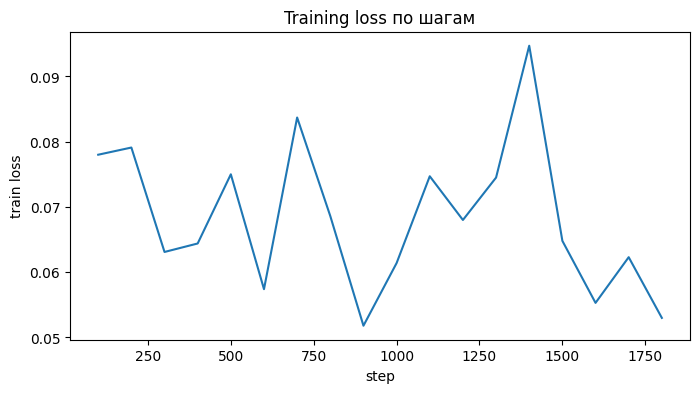

In [ ]:
train_logs = logs.dropna(subset=["loss"])

plt.figure(figsize=(8,4))
plt.plot(train_logs["step"], train_logs["loss"])
plt.xlabel("step")
plt.ylabel("train loss")
plt.title("Training loss по шагам")
plt.show()

График подтверждает, что обучение BERT шло корректно и модель действительно училась, а не стояла на месте. К концу шагов ошибка значительно снизилась.

Сделаем финальная оценку на тесте. Для подсчета F1 на тесте я получаю из модели логиты для тестовых примеров, переводя их в бинарные предсказания через sigmoid и порог 0.5 (аналогично, как в функции для подсчета F1 на валидации), после чего сравниваю с истинными метками.

In [ ]:
preds = trainer.predict(test_ds)

c:\Users\malen\OneDrive\Desktop\data_since\мастерская 1\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
# сырые логиты
logits = preds.predictions.reshape(-1)

# sigmoid
probs = 1 / (1 + np.exp(-logits))

# бинарные предсказания
y_pred = (probs >= 0.5).astype(int)

# истинные метки
y_true = preds.label_ids.reshape(-1).astype(int)

print("Доля комментариев, предсказанные как токсичные:", y_pred.mean())
print("Реальная доля токсичных комментариев:", y_true.mean())

bert_f1 = f1_score(y_true, y_pred)
print("BERT TEST F1:", bert_f1)

Доля комментариев, предсказанные как токсичные: 0.0966445902256819
Реальная доля токсичных комментариев: 0.10160394237107254
BERT TEST F1: 0.9037365421152628


Модель BERT показала высокое качество классификации с F1 = 0.90 на тестовой выборке. Доля предсказанных токсичных комментариев близка к реальной доле токсичных, что говорит о корректной калибровке модели и отсутствии смещения в сторону одного из классов. Полученный результат существенно превосходит качество линейных моделей.

<Figure size 500x500 with 0 Axes>

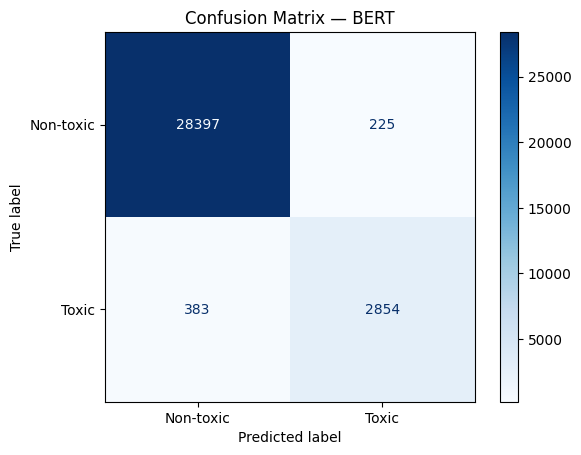

In [ ]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-toxic", "Toxic"]
)

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — BERT")
plt.show()

По сравнению с моделью TF-IDF + LinearSVC, BERT показал более высокое качество классификации: число пропусков токсичных комментариев (FN) снизилось с 906 до 383, а ложных срабатываний (FP) — с 262 до 225. При этом модель BERT обучалась на сокращённой обучающей выборке.

<a id='5'></a>
## Выводы

В ходе исследования была решена задача автоматического выявления токсичных комментариев для сервиса интернет-магазина «Викишоп». 

В качестве базового подхода были рассмотрены линейные модели Logistic Regression и LinearSVC с TF-IDF представлением текста.                 
Наилучший результат показала модель TF-IDF + LinearSVC на лемматизированном тексте с итоговым TEST F1 = 0.799, что превышает требуемый порог качества 0.75. 

Дополнительно была обучена модель BERT (unitary/toxic-bert) с сокращённой обучающей выборкой и облегчёнными параметрами обучения, которая продемонстрировала существенно более высокое качество — TEST F1 = 0.90, а также корректное соответствие доли предсказанных токсичных комментариев к реальному распределению классов. 

Таким образом, обе модели удовлетворяют требованиям задачи, однако использование BERT позволяет значительно повысить качество модерации за счёт более глубокого понимания контекста текста.